In [2]:
import sys
import os
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting
import dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from Fast_BEX import optimized_bex
from Bex import bex
random_state = 1234

In [16]:
pkl_dir = '../V4_Anatomic_DT_LG/26.pkl'

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

pkl_contents = load_pickle_file(pkl_dir)
xgb_model = pkl_contents['model']
dataset = pkl_contents['post_processing_data']

In [17]:
dataset.head()

,Case,Run,snr_ch1,snr_ch2,snr_ch3,WLI_frame_n,WLI_x_coord,WLI_y_coord,score,gt
16658,26,3,35.942778,39.445462,33.650284,14,819,226,0.834515,1
16659,26,3,35.991604,40.653440,34.653813,15,838,227,0.579216,1
16660,26,3,33.736166,36.436199,30.645898,21,810,226,0.540347,1
16661,26,3,35.207742,37.174389,30.612985,22,809,228,0.749529,1
16662,26,3,37.541729,39.906009,34.007619,23,804,228,0.529648,1


In [4]:
df = pd.read_csv("../CSVs and Output Files/HN_P2C_20231207.csv")
cwd = os.getcwd()

/var/folders/6g/jsvgykrx6q53bm52dz7x1ldm0000gn/T/ipykernel_27093/1098886868.py:1: DtypeWarning: Columns (10,12,17,18,19,20,24) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
df.head()

,Case,Run,Anatomy,ScanContext,Instrument,Setup,Diagnosis,HPVstatus,TobbacoStatus,OccultPrimary,...,Phasor_GH3_ch1,Phasor_SH3_ch1,Phasor_GH3_ch2,Phasor_SH3_ch2,Phasor_GH3_ch3,Phasor_SH3_ch3,WLI_frame_n,WLI_x_coord,WLI_y_coord,Label
0,2,1,Palatine Tonsil,In Vivo,V4,TORS Si,Benign,Positive,Reformed Smoker > 15 Years,No,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,581,135,21
1,2,1,Palatine Tonsil,In Vivo,V4,TORS Si,Benign,Positive,Reformed Smoker > 15 Years,No,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,572,126,21
2,2,1,Palatine Tonsil,In Vivo,V4,TORS Si,Benign,Positive,Reformed Smoker > 15 Years,No,...,0.475141,0.423188,0.545914,0.364679,0.469334,0.378082,4,571,129,21
3,2,1,Palatine Tonsil,In Vivo,V4,TORS Si,Benign,Positive,Reformed Smoker > 15 Years,No,...,0.470628,0.373195,0.504433,0.383879,0.457298,0.367506,5,576,125,21
4,2,1,Palatine Tonsil,In Vivo,V4,TORS Si,Benign,Positive,Reformed Smoker > 15 Years,No,...,0.462513,0.363959,0.495915,0.395754,0.464518,0.389213,6,579,120,21


In [6]:
df = df[df['ScanContext'] == 'In Vivo']

# %% SNR and lifetime filtering
index = df[((df['snr_ch1'] < 30) & (df['Instrument'] == 'V4')) |
           ((df['snr_ch2'] < 30) & (df['Instrument'] == 'V4')) |
           ((df['snr_ch3'] < 30) & (df['Instrument'] == 'V4'))].index
df.drop(index, inplace=True)
index = df[((df['snr_ch1'] < 50) & (df['Instrument'] == 'FLImBrush')) |
           ((df['snr_ch2'] < 50) & (df['Instrument'] == 'FLImBrush')) |
           ((df['snr_ch3'] < 50) & (df['Instrument'] == 'FLImBrush'))].index
df.drop(index, inplace=True)

# R_data((R_data.lifet_avg_ch1 > 10 | R_data.lifet_avg_ch1 < 2),:) = [];
index = df[((df['lifet_avg_ch1'] > 16) | (df['lifet_avg_ch1'] < 1)) |
           ((df['lifet_avg_ch2'] > 16) | (df['lifet_avg_ch2'] < 1)) |
           ((df['lifet_avg_ch3'] > 16) | (df['lifet_avg_ch3'] < 1))].index
df.drop(index, inplace=True)

# %% For our current analysis we remove all V4 data and no channel 4 data
index = df[df['Instrument'] == 'FLImBrush'].index
df.drop(index, inplace=True)

# Extract columns based on specific patterns
pattern = r'(Case|Run|snr_|lifet_avg_|spec_int_|int_ratio_|Laguerre_coeffs_|Phasor_GH|Phasor_SH|WLI_)'
selected_columns = df.columns[df.columns.str.contains(pattern)]

# Add the "Label" column, which doesn't fit the patterns
selected_columns = selected_columns.insert(len(selected_columns), 'Label')

subset_df = df[selected_columns]
subset_df = subset_df.dropna()

subset_df = subset_df[subset_df['Label'] != 0]
# Replace values in the 'Label' column
subset_df['Label'] = subset_df['Label'].replace([1, 2, 18, 20, 25, 27, 29, 36, 37], 0)
subset_df['Label'] = subset_df['Label'].replace([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 24, 28, 30, 33], 1)

# Remove rows where 'Label' is not 0 or 1
subset_df = subset_df[subset_df['Label'].isin([0, 1])]

bex_df = optimized_bex(subset_df) #excludes weak labels
#bex_df = bex(subset_df)
f = 1

# Bex(subset_df, l_k=48, f_k1=6, f_k2=47)
# %% For our current analysis we remove all V4 data and no channel 4 data
from scipy.spatial.distance import pdist

pattern = r'(Case|Run|snr_|lifet_avg_|spec_int_|int_ratio_|Laguerre_coeffs_|WLI_)'
selected_columns = df.columns[df.columns.str.contains(pattern)]
selected_columns = selected_columns.insert(len(selected_columns), 'Label')
TrainTest_Data = bex_df[selected_columns]
TrainTest_Data.head()

/var/folders/6g/jsvgykrx6q53bm52dz7x1ldm0000gn/T/ipykernel_27093/3218521333.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/6g/jsvgykrx6q53bm52dz7x1ldm0000gn/T/ipykernel_27093/3218521333.py:50: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


,Case,Run,lifet_avg_ch1,lifet_avg_ch2,lifet_avg_ch3,spec_int_ch1,spec_int_ch2,spec_int_ch3,int_ratio_ch1,int_ratio_ch2,...,Laguerre_coeffs_7_ch3,Laguerre_coeffs_8_ch3,Laguerre_coeffs_9_ch3,Laguerre_coeffs_10_ch3,Laguerre_coeffs_11_ch3,Laguerre_coeffs_12_ch3,WLI_frame_n,WLI_x_coord,WLI_y_coord,Label
0,2,10,3.677834,4.372698,4.673487,0.100970,0.105687,0.056391,0.383847,0.401777,...,0.011809,-0.012513,0.004941,-0.002295,0.001451,-0.000368,3,815,644,0
1,2,10,3.725055,4.311057,4.678097,0.085447,0.083083,0.045521,0.399188,0.388146,...,0.037673,0.003595,0.011348,0.000742,0.001862,-0.000485,4,813,642,0
2,2,10,3.809186,4.337621,4.262062,0.059230,0.059800,0.032438,0.391038,0.394803,...,0.003650,-0.004216,-0.001125,-0.000643,-0.000201,-0.000680,5,814,626,0
3,2,10,3.822145,4.295335,3.905487,0.053078,0.053375,0.029710,0.389809,0.391994,...,0.000380,-0.006706,-0.001397,-0.002114,0.000458,-0.000604,6,814,626,0
4,2,10,3.719731,4.497713,4.277077,0.059476,0.064631,0.036502,0.370316,0.402411,...,0.002631,-0.009467,-0.000464,-0.000858,0.000830,0.000674,7,818,611,0


In [6]:
(dataset.head(50))

,Case,Run,snr_ch1,snr_ch2,snr_ch3,WLI_frame_n,WLI_x_coord,WLI_y_coord,score,gt
2138,25,1,31.911923,34.841784,30.060749,9,685,474,0.598781,1
2139,25,1,31.524589,35.174167,31.011359,14,673,466,0.732532,1
2140,25,1,34.365631,37.667625,32.239650,15,674,467,0.498596,1
2141,25,1,35.723010,36.751284,30.918884,16,678,464,0.775350,1
2142,25,1,35.475074,35.965642,33.528947,18,676,436,0.822335,1
2143,25,1,32.411367,35.551976,30.964674,19,673,432,0.816744,1
2144,25,1,34.680109,33.764948,31.372969,20,673,428,0.548072,1
2145,25,1,38.815759,37.496851,33.001679,22,680,419,0.884777,1
2146,25,1,37.088441,38.863186,30.461608,23,680,419,0.526572,1
2147,25,1,39.041406,38.832264,34.492743,24,681,411,0.889504,1


In [18]:
# target = TrainTest_Data['Label']
# features = TrainTest_Data.drop('Label', axis=1)
# feature_names = (features.columns.tolist())
# target_name = 'Label'

target = dataset['gt']
features = dataset.drop('gt', axis=1)
feature_names = (features.columns.tolist())
target_name = 'gt'

In [19]:
dtrain = xgb.DMatrix(features, target)

params = {"max_depth":3, "eta": 0.05, "objective":"binary:logistic", "subsample":1}
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

viz_model = dtreeviz.model(xgb_model, tree_index=1, X_train = features, y_train = target, feature_names=feature_names, target_name=target_name)

v= viz_model.view()
v.save("tree_test.svg")

In [14]:
x = features.iloc[6]
x

Case            25.000000
Run              1.000000
snr_ch1         34.680109
snr_ch2         33.764948
snr_ch3         31.372969
WLI_frame_n     20.000000
WLI_x_coord    673.000000
WLI_y_coord    428.000000
score            0.548072
Name: 2144, dtype: float64

/Users/vikramkarmarkar/anaconda3/lib/python3.11/site-packages/dtreeviz/models/shadow_decision_tree.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/Users/vikramkarmarkar/anaconda3/lib/python3.11/site-packages/dtreeviz/trees.py:1231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


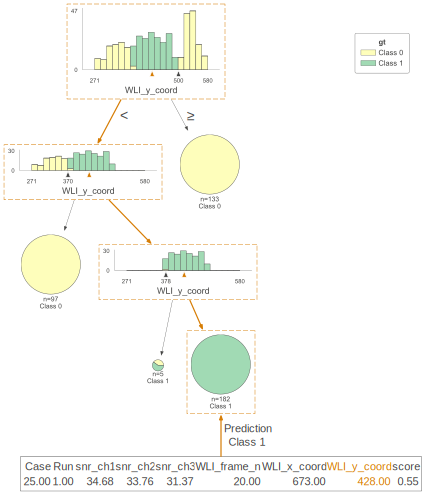

In [15]:
viz_model.view(x=x)

**dtreeviz loop code**

In [ ]:
# import os
# import pickle
# import xgboost as xgb
# import dtreeviz
# 
# pkl_dir = 'V4_Anatomic_DT_LG'
# 
# def load_pickle_file(file_path):
#     with open(file_path, 'rb') as file:
#         data = pickle.load(file)
#     return data
# 
# # Assuming your dataset is in TrainTest_Data for all models:
# target = TrainTest_Data['Label']
# features = TrainTest_Data.drop('Label', axis=1)
# feature_names = features.columns.tolist()
# target_name = 'Label'
# 
# dtrain = xgb.DMatrix(features, target) 
# 
# params = {"max_depth":3, "eta": 0.05, "objective":"binary:logistic", "subsample":1}
# 
# # Loop through the PKL files
# for filename in os.listdir(pkl_dir):
#     if filename.endswith('.pkl'):
#         pkl_path = os.path.join(pkl_dir, filename)
# 
#         # Load the model
#         pkl_contents = load_pickle_file(pkl_path)
#         xgb_model = pkl_contents['model']
# 
#         # Generate the visualization (you might want to iterate tree_index)
#         viz_model = dtreeviz.model(xgb_model, tree_index=1, X_train = features, y_train = target, 
#                                    feature_names=feature_names, target_name=target_name)
#         v = viz_model.view()
# 
#         # Construct the output filename and save
#         output_filename = os.path.splitext(filename)[0] + '_tree.svg'  # Remove .pkl, add _tree.svg
#         output_path = os.path.join(pkl_dir, output_filename)
#         v.save(output_path) 
